In [1]:
import math
import tensorflow as tf
import numpy as np
import h5py
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops
%matplotlib inline
np.random.seed(1)

In [2]:
#loading the dataset
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


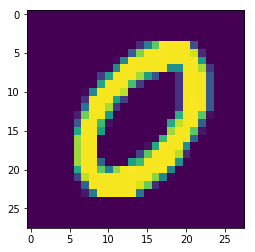

In [3]:
plt.imshow(mnist.train.images[15,:].reshape(28,28))
#mnist.train.images[11,:].reshape(28,28)

In [4]:
mnist.train.labels.T.shape

(10, 55000)

In [31]:
def load_dataset():
    from tensorflow.examples.tutorials.mnist import input_data
    mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
    X_train=mnist.train.images.T
    X_test=mnist.test.images.T
    Y_train=mnist.train.labels.T
    Y_test=mnist.test.labels.T
    return X_train,X_test,Y_train,Y_test

In [32]:
#Provide Mini-batches
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    num_complete_minibatches=int(num_complete_minibatches)
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

result = [[-2.15657382]
 [ 2.95891446]
 [-1.08926781]
 [-0.84538042]]


# 2 - Building your neural network in tensorflow

##### Load Dataset

In [37]:
X_train,  X_test,Y_train, Y_test = load_dataset()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [38]:
X_test.shape

(784, 10000)

In [39]:
# create_placeholders
def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_x -- scalar, size of an image vector (num_px * num_px = 64 * 64 * 3 = 12288)
    n_y -- scalar, number of classes (from 0 to 5, so -> 6)
    
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "float"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "float"
    
    Tips:
    - You will use None because it let's us be flexible on the number of examples you will for the placeholders.
      In fact, the number of examples during test/train is different.
    """
    
    
    X = tf.placeholder(dtype="float", shape=(n_x, None), name='X')
    Y = tf.placeholder(dtype="float", shape=(n_y, None), name='Y')
    
    
    return X, Y

In [40]:
# initialize_parameters
tf.reset_default_graph()
def initialize_parameters():
    #12288 is the size of flattened image, don't worry
    # 25 is the size of nodes in next layer, building features
    # 12 is the size of nodes in next layer, building secondary features
    # 6 is the size of nodes in last layer which is our output
    # We have total of 3 layers in our neural net
    """
    Initializes parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [25, 784]
                        b1 : [25, 1]
                        W2 : [12, 25]
                        b2 : [12, 1]
                        W3 : [6, 12]
                        b3 : [6, 1]
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
    
    tf.set_random_seed(1)                   # so that your "random" numbers match ours
        
    
    W1 = tf.get_variable("W1", [40,784], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b1 = tf.get_variable('b1', [40,1], initializer= tf.zeros_initializer())
    W2 = tf.get_variable('W2', [20,40], initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b2 = tf.get_variable('b2', [20,1], initializer= tf.zeros_initializer())
    W3 = tf.get_variable('W3', [10,20], initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b3 = tf.get_variable('b3', [10,1], initializer= tf.zeros_initializer())
    

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

### Forward Propagation

In [41]:
# forward_propagation

def forward_propagation(X, parameters):
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    
    Z1 = tf.add(tf.matmul(W1, X), b1)                                  # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                              # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)                                 # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                               # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)                           # Z3 = np.dot(W3,Z2) + b3
    
    
    return Z3

<tf.Tensor 'MatMul:0' shape=(25, 2000) dtype=float32>

In [43]:
# GRADED FUNCTION: compute_cost 

def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    '''
    # Minimize error using cross entropy for logistic regression
    cost = tf.reduce_mean(-tf.reduce_sum(y*tf.log(A3), reduction_indices=1))
    '''
    ### START CODE HERE ### (1 line of code)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels))
    ### END CODE HERE ###
    
    return cost

### Building a Model

In [44]:
#Final Model
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 800, minibatch_size = 64, print_cost = True):
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    # Create Placeholders of shape (n_x, n_y)
    ### START CODE HERE ### (1 line)
    X, Y = create_placeholders(n_x, n_y)
    ### END CODE HERE ###

    # Initialize parameters
    ### START CODE HERE ### (1 line)
    parameters = initialize_parameters()
    ### END CODE HERE ###
    
    # Forward propagation: Build the forward propagation in the tensorflow graph

    #X_train=tf.cast(X_train, tf.float32) 
    Z3 = forward_propagation(X, parameters)

    
    # Cost function: Add cost function to tensorflow graph

    cost = compute_cost(Z3, Y)

    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.

    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

Cost after epoch 0: 1.206186
Cost after epoch 100: 0.028724
Cost after epoch 200: 0.002917
Cost after epoch 300: 0.000123
Cost after epoch 400: 0.000015
Cost after epoch 500: 0.000002
Cost after epoch 600: 0.000001
Cost after epoch 700: 0.000000
Cost after epoch 800: 0.000000
Cost after epoch 900: 0.000000
Cost after epoch 1000: 0.000000
Cost after epoch 1100: 0.000000
Cost after epoch 1200: 0.000000
Cost after epoch 1300: 0.000000
Cost after epoch 1400: 0.000000


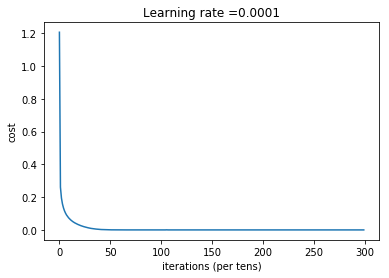

Parameters have been trained!
('Train Accuracy:', 1.0)
('Test Accuracy:', 0.96740001)


In [45]:
parameters = model(X_train, Y_train, X_test, Y_test)

(10, 5000)